In [1]:
# Install yfinance library
%pip install -q yfinance --upgrade --no-cache-dir


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import the necessary libraries
import requests
import pandas as pd
import yfinance as yf
import bs4 as bs
import pickle
import requests
import matplotlib.pyplot as plt
import warnings
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pandas.tseries.offsets import DateOffset
warnings.filterwarnings("ignore")

In [2]:
# !wget --quiet -O "quarterly_statements.csv" "https://raw.githubusercontent.com/pilijevski/stock-prediction/main/lib/quarterly_statements.csv"

In [3]:
stocks = pd.read_csv("./lib/quarterly_statements.csv",index_col=0, parse_dates=True)

In [4]:
def get_snp_companies(subset='500'):
    WIKI_URL = f"http://en.wikipedia.org/wiki/List_of_S%26P_{subset}_companies"
    resp = requests.get(WIKI_URL)
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)

    return tickers

In [5]:
stock_symbols = get_snp_companies('500') + get_snp_companies('400') + get_snp_companies('600')

In [6]:
stocks = stocks.loc['2022-01-01':]
stocks = stocks.loc[stocks.ticker.isin(stock_symbols)]
stocks['end_of_quarter'] = stocks.index

In [7]:
# meta_data = []
# N = 1600
# for ticker in tqdm(stock_symbols):
#   try:
#     stock = yf.Ticker(ticker)
#     stock_info = stock.info
#   except:
#     continue
#   stock_periods = stocks[stocks.ticker == ticker].index

#   if len(stock_periods) < 8:
#     print(f'The stock with ticker:{ticker} has less than 8 periods reported')
#     continue
#   for i in range(len(stock_periods) - 1, -1, -1):
#     stock_features = []

#     try:
#       dividends = stock.dividends[stock_periods[i]- DateOffset(months=3):stock_periods[i]][-1]
#     except:
#       dividends = np.nan

#     try:
#       fte = stock_info['fullTimeEmployees']
#     except:
#       fte = np.nan

#     try:
#       auditrisk = stock_info['auditRisk']
#     except:
#       auditrisk = np.nan
#     try:
#       compensationrisk = stock_info['compensationRisk']
#     except:
#       compensationrisk = np.nan

#     try:
#       boardrisk = stock_info['boardRisk']
#     except:
#       boardrisk = np.nan

#     try:
#       shareholderrightsrisk = stock_info['shareHolderRightsRisk']
#     except:
#       shareholderrightsrisk = np.nan
#     try:
#       maxage = stock_info['maxAge']
#     except:
#       maxage = np.nan
#     try:
#       industry = stock_info['industry']
#     except:
#       industry =  np.nan

#     try:
#       sector = stock_info['sectorKey']
#     except:
#       sector = np.nan
#     stock_features += [stock_periods[i], ticker, industry, sector, fte, auditrisk, compensationrisk,
#                     boardrisk, shareholderrightsrisk, maxage, dividends]
#     hist = stock.history(start=stock_periods[i] - DateOffset(months=3), end=stock_periods[i])
#     try:
#       hist['week_number'] = hist.index.week
#     except:
#       continue
#     weekly_mean_close = hist.groupby('week_number')['Close'].mean()
#     stock_features += list(weekly_mean_close.values[:10])
#     stock_feature_columns = ['end_of_quarter','ticker', 'industry', 'sector', 'fte', 'auditrisk',
#                             'compensationrisk', 'boardrisk', 'shareholderrightsrisk',
#                             'maxage', 'dividends'] + [f'weekly_price_{w}' for w in range(len(list(weekly_mean_close.values[:10])))] + ['increase']

#     try:
#       hist = stock.history(start=stock_periods[i], end=stock_periods[i] + DateOffset(months=3))
#       next_quarter_increase = (hist['Close'][-1] - hist['Close'][0]) / hist['Close'][0]
#       stock_features += [next_quarter_increase]
#       meta_data.append(stock_features)
#     except:
#       continue
#   if N < 0:
#     break
#   N -= 1

In [8]:
# meta_df = pd.DataFrame(meta_data, columns=stock_feature_columns)
# meta_df.to_csv('/content/drive/MyDrive/Colab Notebooks/stocks/meta_df.csv', index=False)

In [9]:
meta_df = pd.read_csv('meta_df.csv')
meta_df.end_of_quarter = pd.to_datetime(meta_df.end_of_quarter)

In [10]:
df = pd.merge(stocks, meta_df, how='left', on=['ticker', 'end_of_quarter'])
df.head(5)

,Cash & Equivalents,Short-Term Investments,Cash & Cash Equivalents,Cash Growth,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant & Equipment",Long-Term Investments,...,weekly_price_1,weekly_price_2,weekly_price_3,weekly_price_4,weekly_price_5,weekly_price_6,weekly_price_7,weekly_price_8,weekly_price_9,increase
0,"13,715","15,432","29,147",13.78%,"4,884","3,209","4,887","42,127","2,005","3,364",...,50.278000,50.727500,51.822000,51.161896,51.925947,52.394304,50.503018,47.755897,47.764330,-0.046089
1,"9,602","17,335","26,937",14.79%,"4,833","3,342","4,547","39,659","2,004","3,324",...,51.831433,52.454056,53.190958,54.739635,56.107043,56.124774,55.547469,54.057901,52.613651,0.018920
2,"10,123","19,375","29,498",27.30%,"5,854","3,644","4,352","43,348","2,085","3,483",...,45.484898,46.732506,47.915582,48.789690,48.719293,50.107695,49.828548,49.843703,50.499490,-0.002068
3,"8,044","18,646","26,690",11.62%,"5,104","3,474","4,682","39,950","2,047","3,393",...,45.875569,47.701974,47.719929,47.222565,47.515646,47.907711,48.777243,49.650657,50.556973,0.108682
4,"9,009","16,609","25,618",2.02%,"5,237","3,140","4,520","38,515","1,964","3,554",...,47.451596,45.664979,46.609238,43.940697,43.099239,43.039547,43.981135,46.446299,47.320010,-0.027173


In [11]:
# df.to_csv('/content/drive/MyDrive/Colab Notebooks/stocks/stocks_processed.csv', index=False)

In [12]:
# df = pd.read_csv('stocks_processed.csv')

In [13]:
# We keep only ratios for now, we don't know how to normalize other values e.g., Cash Flow properly
features = ['ticker', 'Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','industry', 'sector', 'fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk','end_of_quarter','increase']

numerical_features = ['Net Cash / Debt','Net Cash / Debt Growth','Net Cash Per Share', 'Book Value Per Share',
         'Share Issuance / Repurchase', 'Debt Issued / Paid', 'Cash Growth', 'Debt Growth', 'Free Cash Flow Growth',
         'Free Cash Flow Margin', 'Free Cash Flow Per Share', 'Revenue Growth (YoY)', 'Interest Expense / Income',
         'Other Expense / Income', 'Net Income Growth', 'EPS (Basic)', 'EPS (Diluted)', 'EPS Growth', 'Free Cash Flow Per Share.1',
         'Dividend Per Share', 'Dividend Growth', 'Gross Margin', 'Operating Margin', 'Profit Margin', 'EBIT Margin',
         'Market Cap Growth', 'PE Ratio', 'PS Ratio', 'PB Ratio', 'P/FCF Ratio', 'P/OCF Ratio', 'Debt / Equity Ratio',
         'Quick Ratio','Current Ratio','Interest Coverage', 'Return on Capital (ROIC)','Dividend Yield','Payout Ratio',
         'Buyback Yield / Dilution', 'Total Shareholder Return', 'Return on Equity (ROE)', 'Return on Assets (ROA)', 'Earnings Yield',
         'FCF Yield','fte', 'auditrisk', 'compensationrisk', 'boardrisk','shareholderrightsrisk']#,'increase']

# df = df[features]

In [14]:
# df = df.loc[df.end_of_quarter > '2023-01-01']

In [15]:
# remove commas from thousands, and replace values that have only '-' with nan
tmp = df['end_of_quarter'].copy()
for col in list(df.columns):
  try:
    df.loc[:, col] = df.loc[:, col].str.replace(',', '').replace(r'^-$', np.nan, regex=True)
  except:
    pass
# all percentage columns, remove the percent sign
percentage_columns = [col for col in df.columns if any(df[col].astype(str).str.contains('%'))]
for col in percentage_columns:
  df.loc[:, col] = df.loc[:, col].str.replace('%', '')
df['end_of_quarter'] = tmp

### Feature design by definitions 

In [16]:
_CALCULATED = '_calculated'

In [17]:
df[f"Return on Equity (ROE){_CALCULATED}"] = 100 * df['Net Income'].astype('float')/df["Shareholders' Equity"].astype('float')

In [18]:
df[f'Asset Turnover{_CALCULATED}'] = df['Revenue'].astype('float')/df['Total Assets'].astype('float')

In [19]:
df[f"Return on Assets (ROA){_CALCULATED}"] = 100 * df['Net Income'].astype('float')/df["Total Assets"].astype('float')

In [20]:
# avoid inf, add 10e-5
df[f'Earnings Yield{_CALCULATED}'] = 1 / (df[ 'PE Ratio'].astype('float') + 10e-5)

In [21]:
df[f'Share Price{_CALCULATED}'] = df['PE Ratio'].astype('float') * df['EPS (Basic)'].astype('float')

In [22]:
df[f'FCF Yield{_CALCULATED}'] = df['Free Cash Flow Per Share'].astype('float')/ (df[f'Share Price{_CALCULATED}'].astype('float') + 10e-5)

In [23]:
df[['Dividend Per Share', 'Shares Outstanding (Basic)']].isna().sum()

Dividend Per Share            4341
Shares Outstanding (Basic)      88
dtype: int64

In [24]:
df[f'DPS{_CALCULATED}'] = -1* df[ 'Dividends Paid'].astype('float') / (df['Shares Outstanding (Basic)'].astype('float') + 10e-5)

In [25]:
df[f'Dividents{_CALCULATED}'] = df[f'DPS{_CALCULATED}'].astype('float') * df['Shares Outstanding (Basic)'].astype('float')

In [26]:
df[[ 'dividends', f'DPS{_CALCULATED}',  'Dividend Per Share']].isna().sum()

dividends             10959
DPS_calculated         3086
Dividend Per Share     4341
dtype: int64

# missing values analysis

In [27]:
missing_pct = df[numerical_features].isna().mean()
columns_missing = missing_pct[missing_pct > .20].index
df[columns_missing]

,Net Cash / Debt Growth,Net Cash Per Share,Free Cash Flow Growth,Net Income Growth,EPS Growth,Dividend Per Share,Dividend Growth,Quick Ratio,Current Ratio,Dividend Yield,Payout Ratio,Return on Equity (ROE),Return on Assets (ROA),Earnings Yield,FCF Yield
0,4.85,4.31,-86.04,-5.01,-2.99,0.390,2.63,1.10,1.37,3.00,60.00,NaN,NaN,NaN,NaN
1,32.20,4.72,-40.91,36.25,36.92,0.390,2.63,1.18,1.47,3.00,43.30,NaN,NaN,NaN,NaN
2,54.55,5.16,58.27,40.60,41.18,0.390,2.63,1.13,1.39,3.00,40.20,NaN,NaN,NaN,NaN
3,26.23,4.45,39.20,5.52,6.85,0.390,2.63,1.11,1.39,3.20,49.40,NaN,NaN,NaN,NaN
4,22.67,4.06,94.01,-6.73,-5.63,0.380,2.70,1.13,1.41,3.10,55.90,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12047,NaN,-5.57,NaN,-21.24,-21.39,0.150,200.00,1.45,1.67,0.80,10.90,NaN,NaN,NaN,NaN
12048,NaN,-5.07,NaN,18.16,17.32,0.100,100.00,1.66,1.86,0.50,4.70,NaN,NaN,NaN,NaN
12049,NaN,-6.27,99.68,65.78,64.91,0.100,300.00,1.33,1.48,0.50,3.50,NaN,NaN,NaN,NaN
12050,NaN,-8.66,290.62,292.54,289.89,0.050,100.00,1.17,1.32,0.40,1.40,NaN,NaN,NaN,NaN


In [28]:
df[columns_missing].isna().sum()

Net Cash / Debt Growth     9902
Net Cash Per Share         2483
Free Cash Flow Growth      4232
Net Income Growth          2517
EPS Growth                 2571
Dividend Per Share         4341
Dividend Growth            4899
Quick Ratio                2686
Current Ratio              2686
Dividend Yield             3200
Payout Ratio               3219
Return on Equity (ROE)    11881
Return on Assets (ROA)    11881
Earnings Yield            11882
FCF Yield                 11883
dtype: int64

In [29]:
import seaborn as sns

In [30]:
df["Net Cash / Debt Growth"].astype('float').dropna().mean()

284.3717488372093

In [31]:
df["Net Cash / Debt Growth"].astype('float').dropna().median()

-0.6699999999999999

- non-nan distributions of the features with a lot of missing values tend to be 0 centered

In [32]:
columns_missing[:15]

Index(['Net Cash / Debt Growth', 'Net Cash Per Share', 'Free Cash Flow Growth',
       'Net Income Growth', 'EPS Growth', 'Dividend Per Share',
       'Dividend Growth', 'Quick Ratio', 'Current Ratio', 'Dividend Yield',
       'Payout Ratio', 'Return on Equity (ROE)', 'Return on Assets (ROA)',
       'Earnings Yield', 'FCF Yield'],
      dtype='object')

Net Cash / Debt Growth: -0.6699999999999999
Net Cash Per Share: -10.89
Free Cash Flow Growth: 4.715
Net Income Growth: 3.32
EPS Growth: 4.55
Dividend Per Share: 0.347
Dividend Growth: 5.88
Quick Ratio: 1.02
Current Ratio: 1.62
Dividend Yield: 2.1
Payout Ratio: 28.6
Return on Equity (ROE): 17.88
Return on Assets (ROA): 8.68
Earnings Yield: 1.17
FCF Yield: 1.2


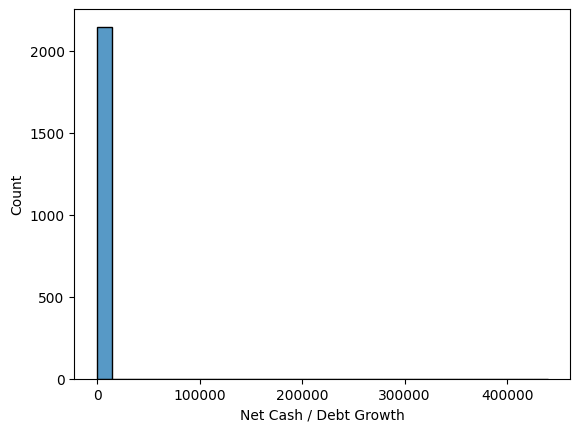

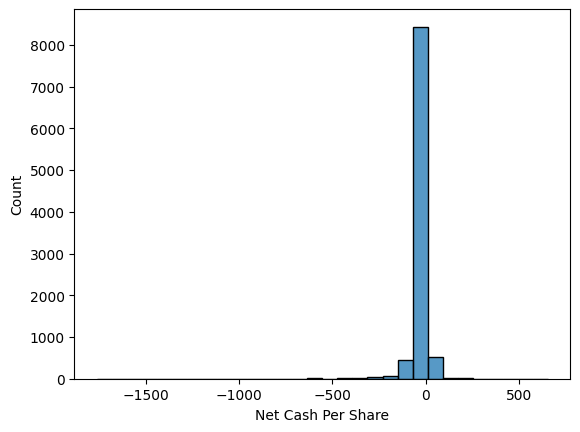

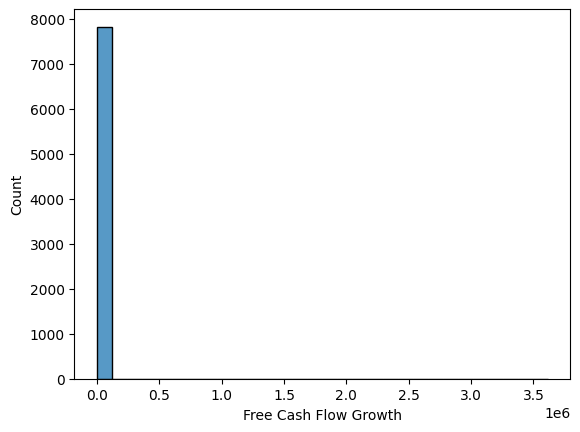

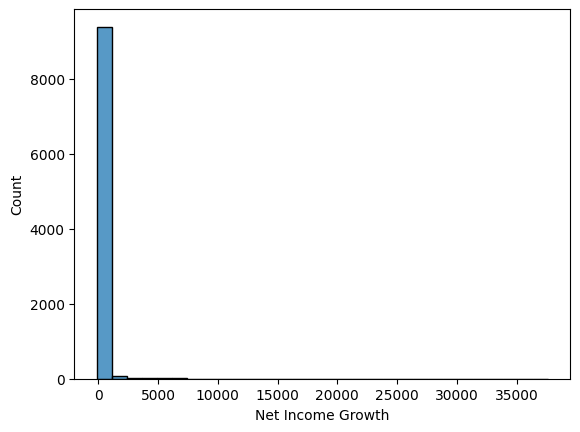

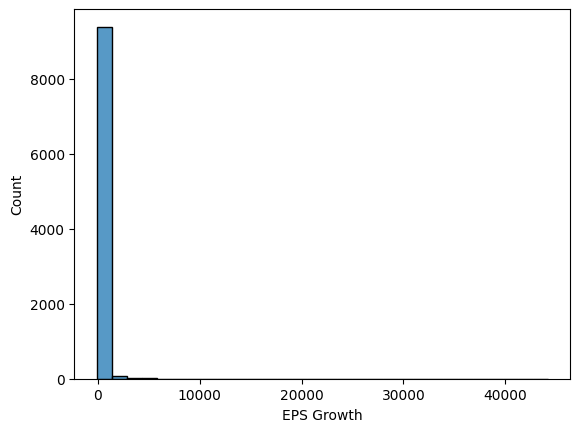

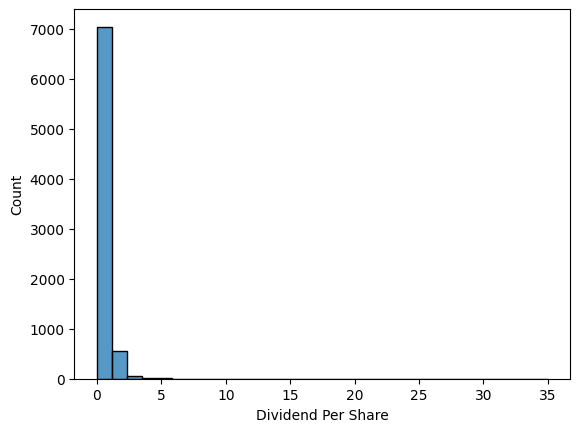

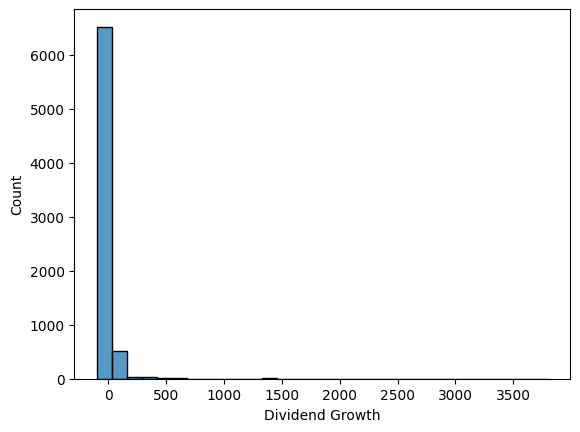

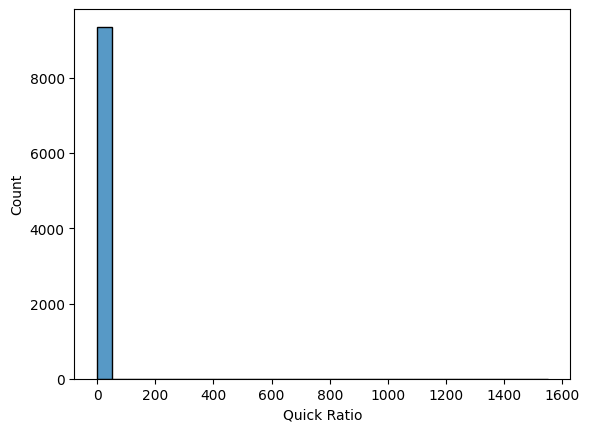

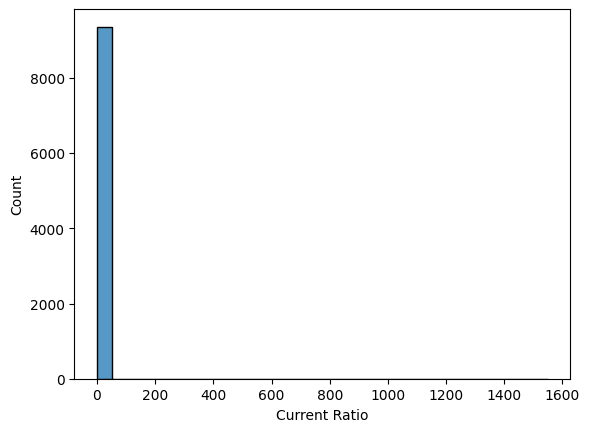

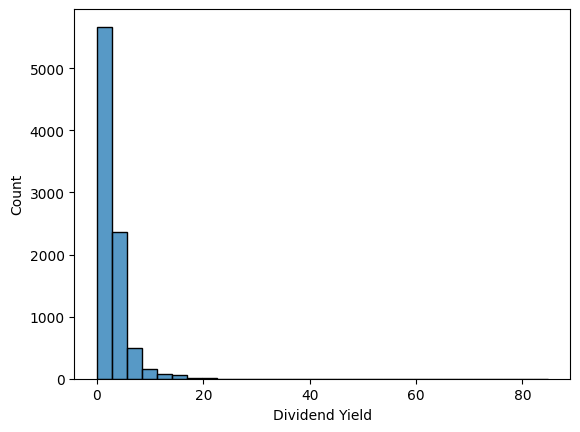

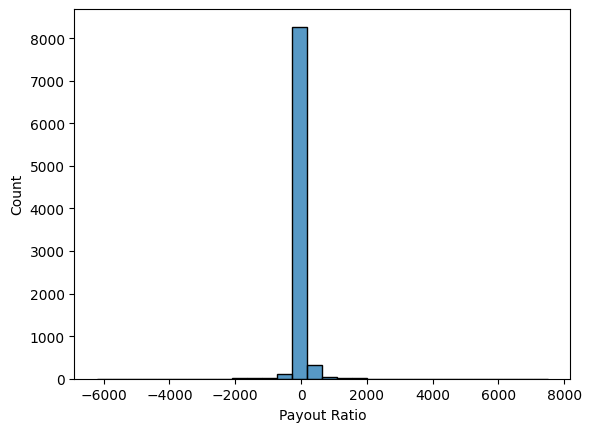

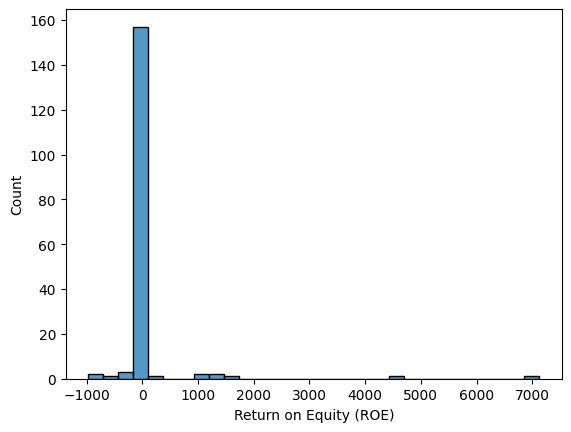

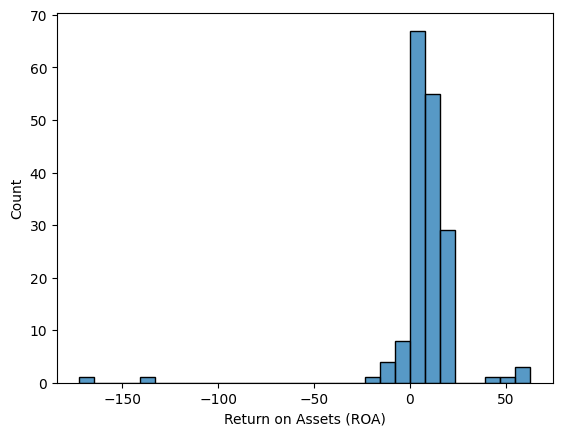

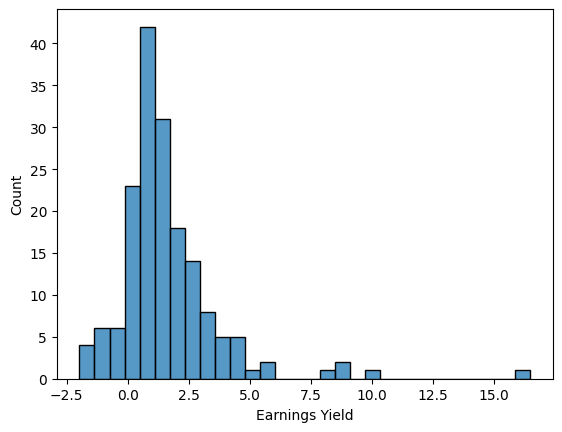

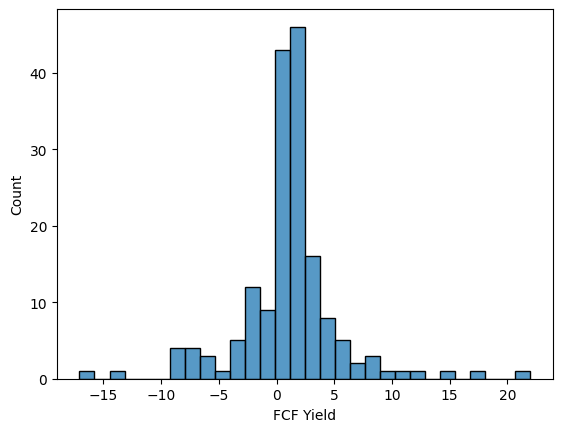

In [33]:
for c in columns_missing[:15]:
    plt.figure()
    print(f"{c}: {df[c].astype('float').median()}")
    sns.histplot(df[c].astype('float').dropna(), bins = 30)

In [34]:
# get all new created features
new_features = [c for c in df.columns if _CALCULATED in c]

In [35]:
df[new_features].isna().sum()

Return on Equity (ROE)_calculated      57
Asset Turnover_calculated              54
Return on Assets (ROA)_calculated      57
Earnings Yield_calculated              98
Share Price_calculated                143
FCF Yield_calculated                  226
DPS_calculated                       3086
Dividents_calculated                 3086
dtype: int64

In [36]:
numerical_features += new_features

In [37]:
features += new_features

# Feat norm 

In [38]:
# normalizing the values by dividing by total_revenue as suggested by financial books, in order for us to be able to compare companies on the more or less same scale
df[numerical_features] = df[numerical_features].astype('float')
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].astype('float').median())

In [39]:
df['increase'] = df['increase'].astype('float')

In [40]:
df = df[features]

In [41]:
# Should we scale ratios? Ratios are already scaled
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# cols = [x for x in df.columns if x not in ['industry', 'sector','ticker', 'end_of_quarter','increase'] and x not in numerical_features]
# # Fit and transform the DataFrame
# df[cols] = scaler.fit_transform(df[cols])

In [42]:
# not needed since we are not dividing with 0 nowhere
# df.replace([np.inf, -np.inf], df., inplace=True)

In [43]:
# one hot encoding of industry and sector
one_hot_encoded_industry = pd.get_dummies(df['industry'], prefix='industry')
one_hot_encoded_sector = pd.get_dummies(df['sector'], prefix='sector')
df = pd.concat([df, one_hot_encoded_industry, one_hot_encoded_sector], axis=1)
df.drop(['industry', 'sector'], axis=1, inplace=True)

In [44]:
df.increase.max(), df.increase.min()

(2.4037833028603024, -0.6380806484245339)

In [45]:
# where target variable does not exists, remove those rows
df.dropna(axis=0, inplace=True, subset=['increase'])

In [46]:
df_test = df.groupby('ticker', as_index=False).first()
df_train = df.loc[~df.end_of_quarter.isin(df_test.end_of_quarter)]
df_train.shape, df_test.shape

((10246, 228), (1465, 228))

In [47]:
y_train = df_train[['increase', 'ticker']]
y_test = df_test[['increase', 'ticker']]
df_test = df_test.drop(['ticker', 'end_of_quarter', 'increase'], axis=1)
df_train = df_train.drop(['ticker', 'end_of_quarter', 'increase'], axis=1)

In [48]:
y_train['increase_real_values'] = y_train.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
y_train.increase[y_train.increase_real_values >= class_thresholds[3]] = 4
y_train.increase[(y_train.increase_real_values >= class_thresholds[2]) & (y_train.increase_real_values < class_thresholds[3])] = 3
y_train.increase[(y_train.increase_real_values >= class_thresholds[1]) & (y_train.increase_real_values < class_thresholds[2])] = 2
y_train.increase[(y_train.increase_real_values > class_thresholds[0]) & (y_train.increase_real_values < class_thresholds[1])] = 1
y_train.increase[y_train.increase_real_values <= class_thresholds[0]] = 0

In [49]:
class_counts = dict(zip(*np.unique(y_train.increase.values, return_counts=True)))
class_weights = {class_label: len(y_train.increase.values) / (len(np.unique(y_train.increase.values)) * count) for class_label, count in class_counts.items()}
class_counts, class_weights

({0.0: 2610, 1.0: 2519, 2.0: 2242, 3.0: 1589, 4.0: 1286},
 {0.0: 0.7851340996168582,
  1.0: 0.8134974196109567,
  2.0: 0.9140053523639607,
  3.0: 1.2896161107614852,
  4.0: 1.5934681181959565})

In [50]:
df_train.fillna(np.iinfo('int').max, inplace=True)
df_test.fillna(np.iinfo('int').max, inplace=True)

In [51]:
# Assuming you have your features (x) and labels (y) ready, split the data.
X_train, X_test, Y_train, Y_test = train_test_split(df_train, y_train, test_size=0.1, random_state=42)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost
# We fit a classifier to predict the increase in percentage into the next Q
# Initialize
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42) # , class_weight=class_weights)
# rf_classifier = xgboost.XGBClassifier(n_estimators=500, random_state = 42, verbose=True, max_depth = 7, objective='multi:softmax')
# rf_classifier = LogisticRegression(random_state=42)
# Fit the model to the training data
rf_classifier.fit(X_train, Y_train.increase)

RandomForestClassifier(n_estimators=300, random_state=42)

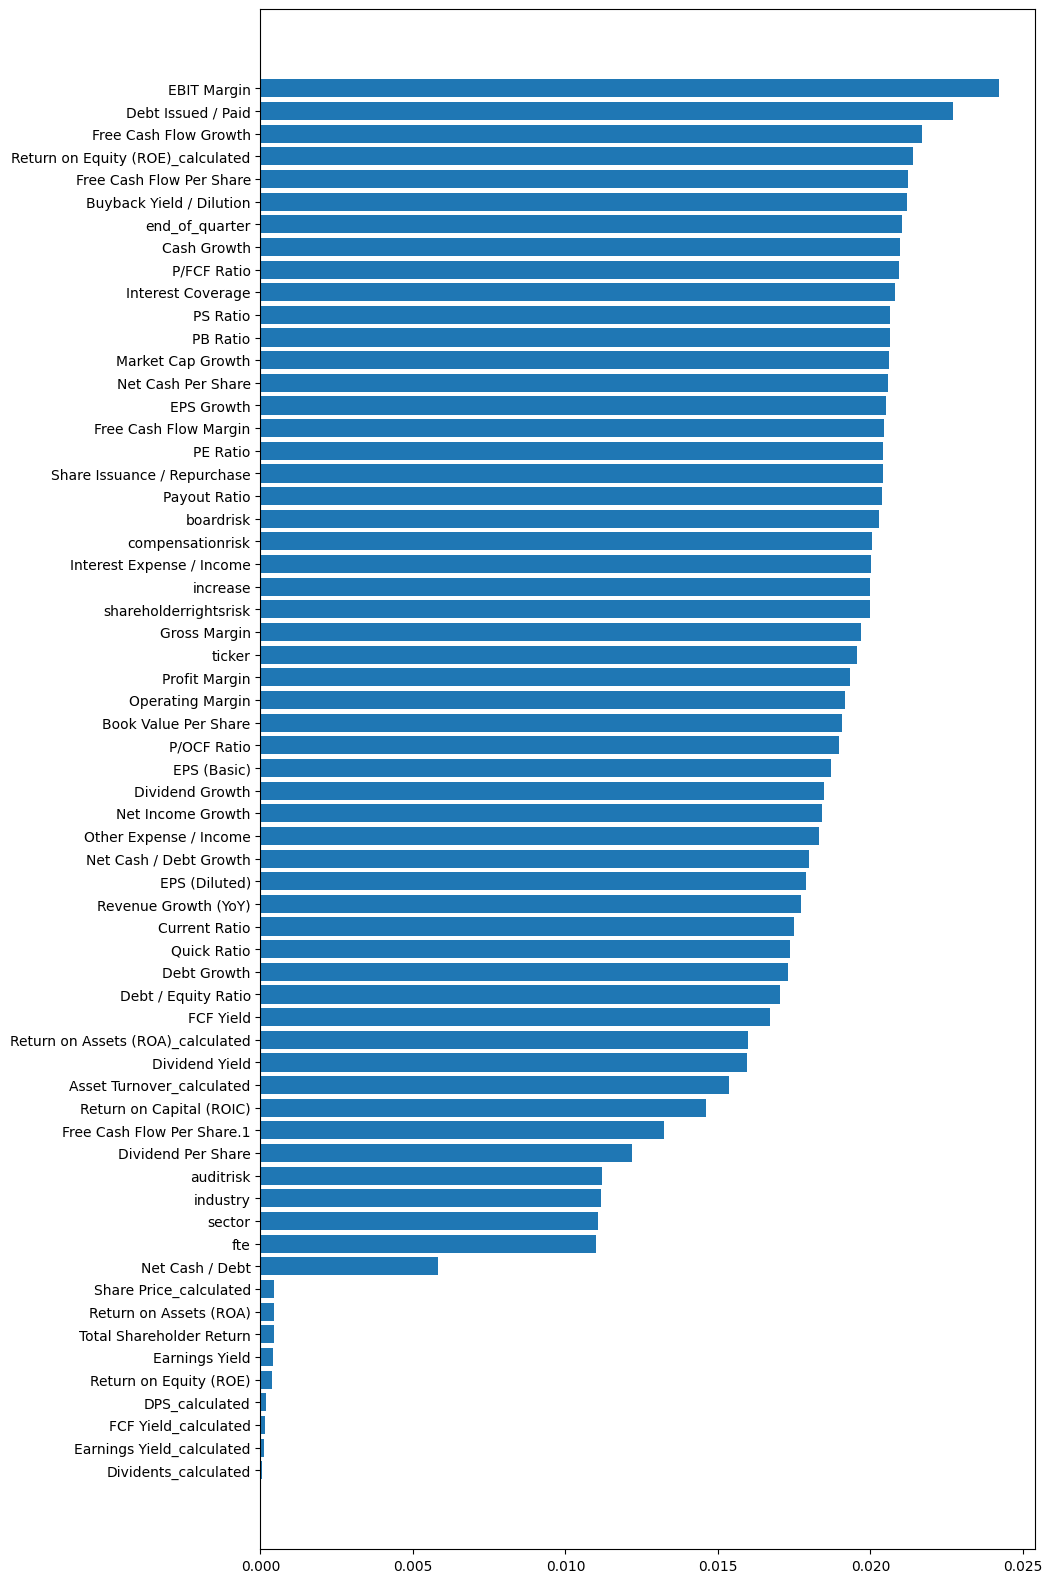

In [53]:
# plot top features by importance
f_i = list(zip(features,rf_classifier.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.figure(figsize=(10,20))
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

# New features:

In [54]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
7725,KBH,4.0,2.0,0.074346
416,MDC,4.0,0.0,-0.118452
10883,HZO,4.0,1.0,-0.076751
10038,SLP,4.0,2.0,0.028513
2231,SBSI,4.0,2.0,0.098562
10039,SLP,4.0,3.0,0.183754
1217,SABR,4.0,0.0,-0.345779
10446,ZION,4.0,4.0,0.309943
2921,DCOM,4.0,4.0,0.366312
1265,BLDR,4.0,4.0,0.319816


In [55]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,0.0,402,259
1,1.0,316,259
2,2.0,191,234
3,3.0,69,142
4,4.0,47,131


In [56]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.3102439024390244
Confusion matrix: 
 [[142  53  42  13   9]
 [ 86 102  49  13   9]
 [ 79  73  49  21  12]
 [ 44  47  31  14   6]
 [ 51  41  20   8  11]]


In [57]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
K = 10
p.sort_values(by='preds')[::-1][:K]

,ticker,preds,increase
182,BLDR,4.0,0.276575
88,ANET,4.0,0.315426
1347,URI,4.0,0.267942
466,ETSY,4.0,-0.159965
99,APH,4.0,0.183938
413,DXCM,4.0,0.083841
213,CAH,4.0,0.096570
603,HBAN,4.0,0.058320
509,FI,3.0,0.174932
841,META,3.0,0.466285


In [58]:
f'We have gain (positive) or loss (negative) of {p.sort_values(by="preds")[::-1][:K].increase.mean() * 100}% on the invested {K} stocks'

'We have gain (positive) or loss (negative) of 17.63865213167238% on the invested 10 stocks'

In [59]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0

In [60]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

Accuracy: 0.25851703406813625
Confusion matrix: 
 [[18 17  3  1  1]
 [27 61 17  1  0]
 [36 84 31 10  3]
 [24 49 33 16  1]
 [19 12 20 12  3]]


In [61]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,223,164
1,0.0,124,123
2,2.0,104,106
3,3.0,40,66
4,4.0,8,40


# fillna median:

In [82]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
3476,GMS,4.0,1.0,-0.021241
875,DGII,4.0,2.0,0.092937
11030,MHO,4.0,1.0,-0.036128
7666,ARCB,4.0,2.0,0.028846
10039,SLP,4.0,3.0,0.183754
362,TER,4.0,3.0,0.110052
4290,WGO,4.0,1.0,-0.000845
11029,MHO,4.0,4.0,0.653145
3943,MLI,4.0,2.0,0.032526
1217,SABR,4.0,0.0,-0.345779


In [83]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,0.0,353,259
1,1.0,313,259
2,2.0,221,234
3,3.0,82,142
4,4.0,56,131


In [84]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.29853658536585365
Confusion matrix: 
 [[128  57  49  14  11]
 [ 74  93  57  25  10]
 [ 70  80  53  19  12]
 [ 37  46  34  17   8]
 [ 44  37  28   7  15]]


In [85]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
K = 10
p.sort_values(by='preds')[::-1][:K]

,ticker,preds,increase
182,BLDR,4.0,0.276575
1396,WAT,4.0,0.072515
603,HBAN,4.0,0.058320
736,KLAC,4.0,0.272560
235,CCL,4.0,0.027224
1347,URI,4.0,0.267942
147,BAC,4.0,0.114284
71,AMD,4.0,0.289363
137,AXON,4.0,0.256170
88,ANET,4.0,0.315426


In [86]:
f'We have gain (positive) or loss (negative) of {p.sort_values(by="preds")[::-1][:K].increase.mean() * 100}% on the invested {K} stocks'

'We have gain (positive) or loss (negative) of 19.503807971647312% on the invested 10 stocks'

In [87]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0

In [88]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

Accuracy: 0.312625250501002
Confusion matrix: 
 [[15 20  2  3  0]
 [17 63 24  2  0]
 [22 76 53 10  3]
 [23 46 34 19  1]
 [12 21 14 13  6]]


In [89]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,226,164
1,2.0,127,123
2,0.0,89,106
3,3.0,47,66
4,4.0,10,40


# Baseline output:

In [80]:
# Predict on the test set
rf_classifier.predict(X_test)
ticker = Y_test.ticker
p = pd.DataFrame({"ticker": ticker, "preds": rf_classifier.predict(X_test), "true": Y_test.increase, "increase": Y_test.increase_real_values})
# Select the top K stocks that we would invest (still this data is older, just for sanity check and to check for underfitting)
K = 10
p.sort_values(by='preds')[::-1].iloc[:K]

,ticker,preds,true,increase
6160,RAMP,4.0,2.0,0.009804
10446,ZION,4.0,4.0,0.309943
2999,NVRI,4.0,2.0,0.048589
858,BSIG,4.0,0.0,-0.148806
6208,SBCF,4.0,1.0,-0.006335
7456,POWL,4.0,4.0,0.368213
8254,PBI,4.0,0.0,-0.146893
10829,X,4.0,4.0,0.298680
1353,BLD,4.0,4.0,0.255382
418,MDC,4.0,3.0,0.184194


In [81]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.true.value_counts().values})

,value,pred_counts,true_counts
0,0.0,382,259
1,1.0,329,259
2,2.0,208,234
3,3.0,67,142
4,4.0,39,131


In [82]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(p.true, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.true, p.preds)}')

Accuracy: 0.31121951219512195
Confusion matrix: 
 [[136  65  41  11   6]
 [ 79 101  50  20   9]
 [ 71  86  54  15   8]
 [ 48  41  35  15   3]
 [ 48  36  28   6  13]]


In [83]:
# predicting on the SNP 500 stocks
p = pd.DataFrame({"ticker": y_test.loc[y_test.ticker.isin(get_snp_companies('500'))].ticker, "preds": rf_classifier.predict(df_test.loc[y_test.ticker.isin(get_snp_companies('500'))]), "increase": y_test.increase.loc[y_test.ticker.isin(get_snp_companies('500'))]})
# selecting the top K stocks we want to put money in
K = 10
p.sort_values(by='preds')[::-1][:K]

,ticker,preds,increase
88,ANET,4.0,0.315426
184,BLK,4.0,0.058710
252,CFG,4.0,0.078878
1347,URI,4.0,0.267942
71,AMD,4.0,0.289363
1393,WAB,4.0,0.150687
1396,WAT,4.0,0.072515
235,CCL,4.0,0.027224
920,NFLX,4.0,0.329157
1368,VLO,4.0,0.308587


In [84]:
f'We have gain (positive) or loss (negative) of {p.sort_values(by="preds")[::-1][:K].increase.mean() * 100}% on the invested {K} stocks'

'We have gain (positive) or loss (negative) of 18.984905341196594% on the invested 10 stocks'

In [85]:
p['increase_real_values'] = p.increase
class_thresholds = [-0.1, 0.0, 0.1, 0.2]
p.increase[p.increase_real_values >= class_thresholds[3]] = 4
p.increase[(p.increase_real_values >= class_thresholds[2]) & (p.increase_real_values < class_thresholds[3])] = 3
p.increase[(p.increase_real_values >= class_thresholds[1]) & (p.increase_real_values < class_thresholds[2])] = 2
p.increase[(p.increase_real_values > class_thresholds[0]) & (p.increase_real_values < class_thresholds[1])] = 1
p.increase[p.increase_real_values <= class_thresholds[0]] = 0

In [86]:
# Compute accuracy on test
accuracy = accuracy_score(p.increase, p.preds)
print("Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix: \n {confusion_matrix(p.increase, p.preds)}')

Accuracy: 0.28857715430861725
Confusion matrix: 
 [[21 14  3  1  1]
 [20 66 17  3  0]
 [30 82 38 10  4]
 [25 44 40 13  1]
 [19 12 19 10  6]]


In [87]:
pd.DataFrame({"value": p.preds.value_counts().index, "pred_counts": p.preds.value_counts().values, "true_counts": p.increase.value_counts().values})

,value,pred_counts,true_counts
0,1.0,218,164
1,2.0,117,123
2,0.0,115,106
3,3.0,37,66
4,4.0,12,40


<Figure size 1600x1600 with 0 Axes>

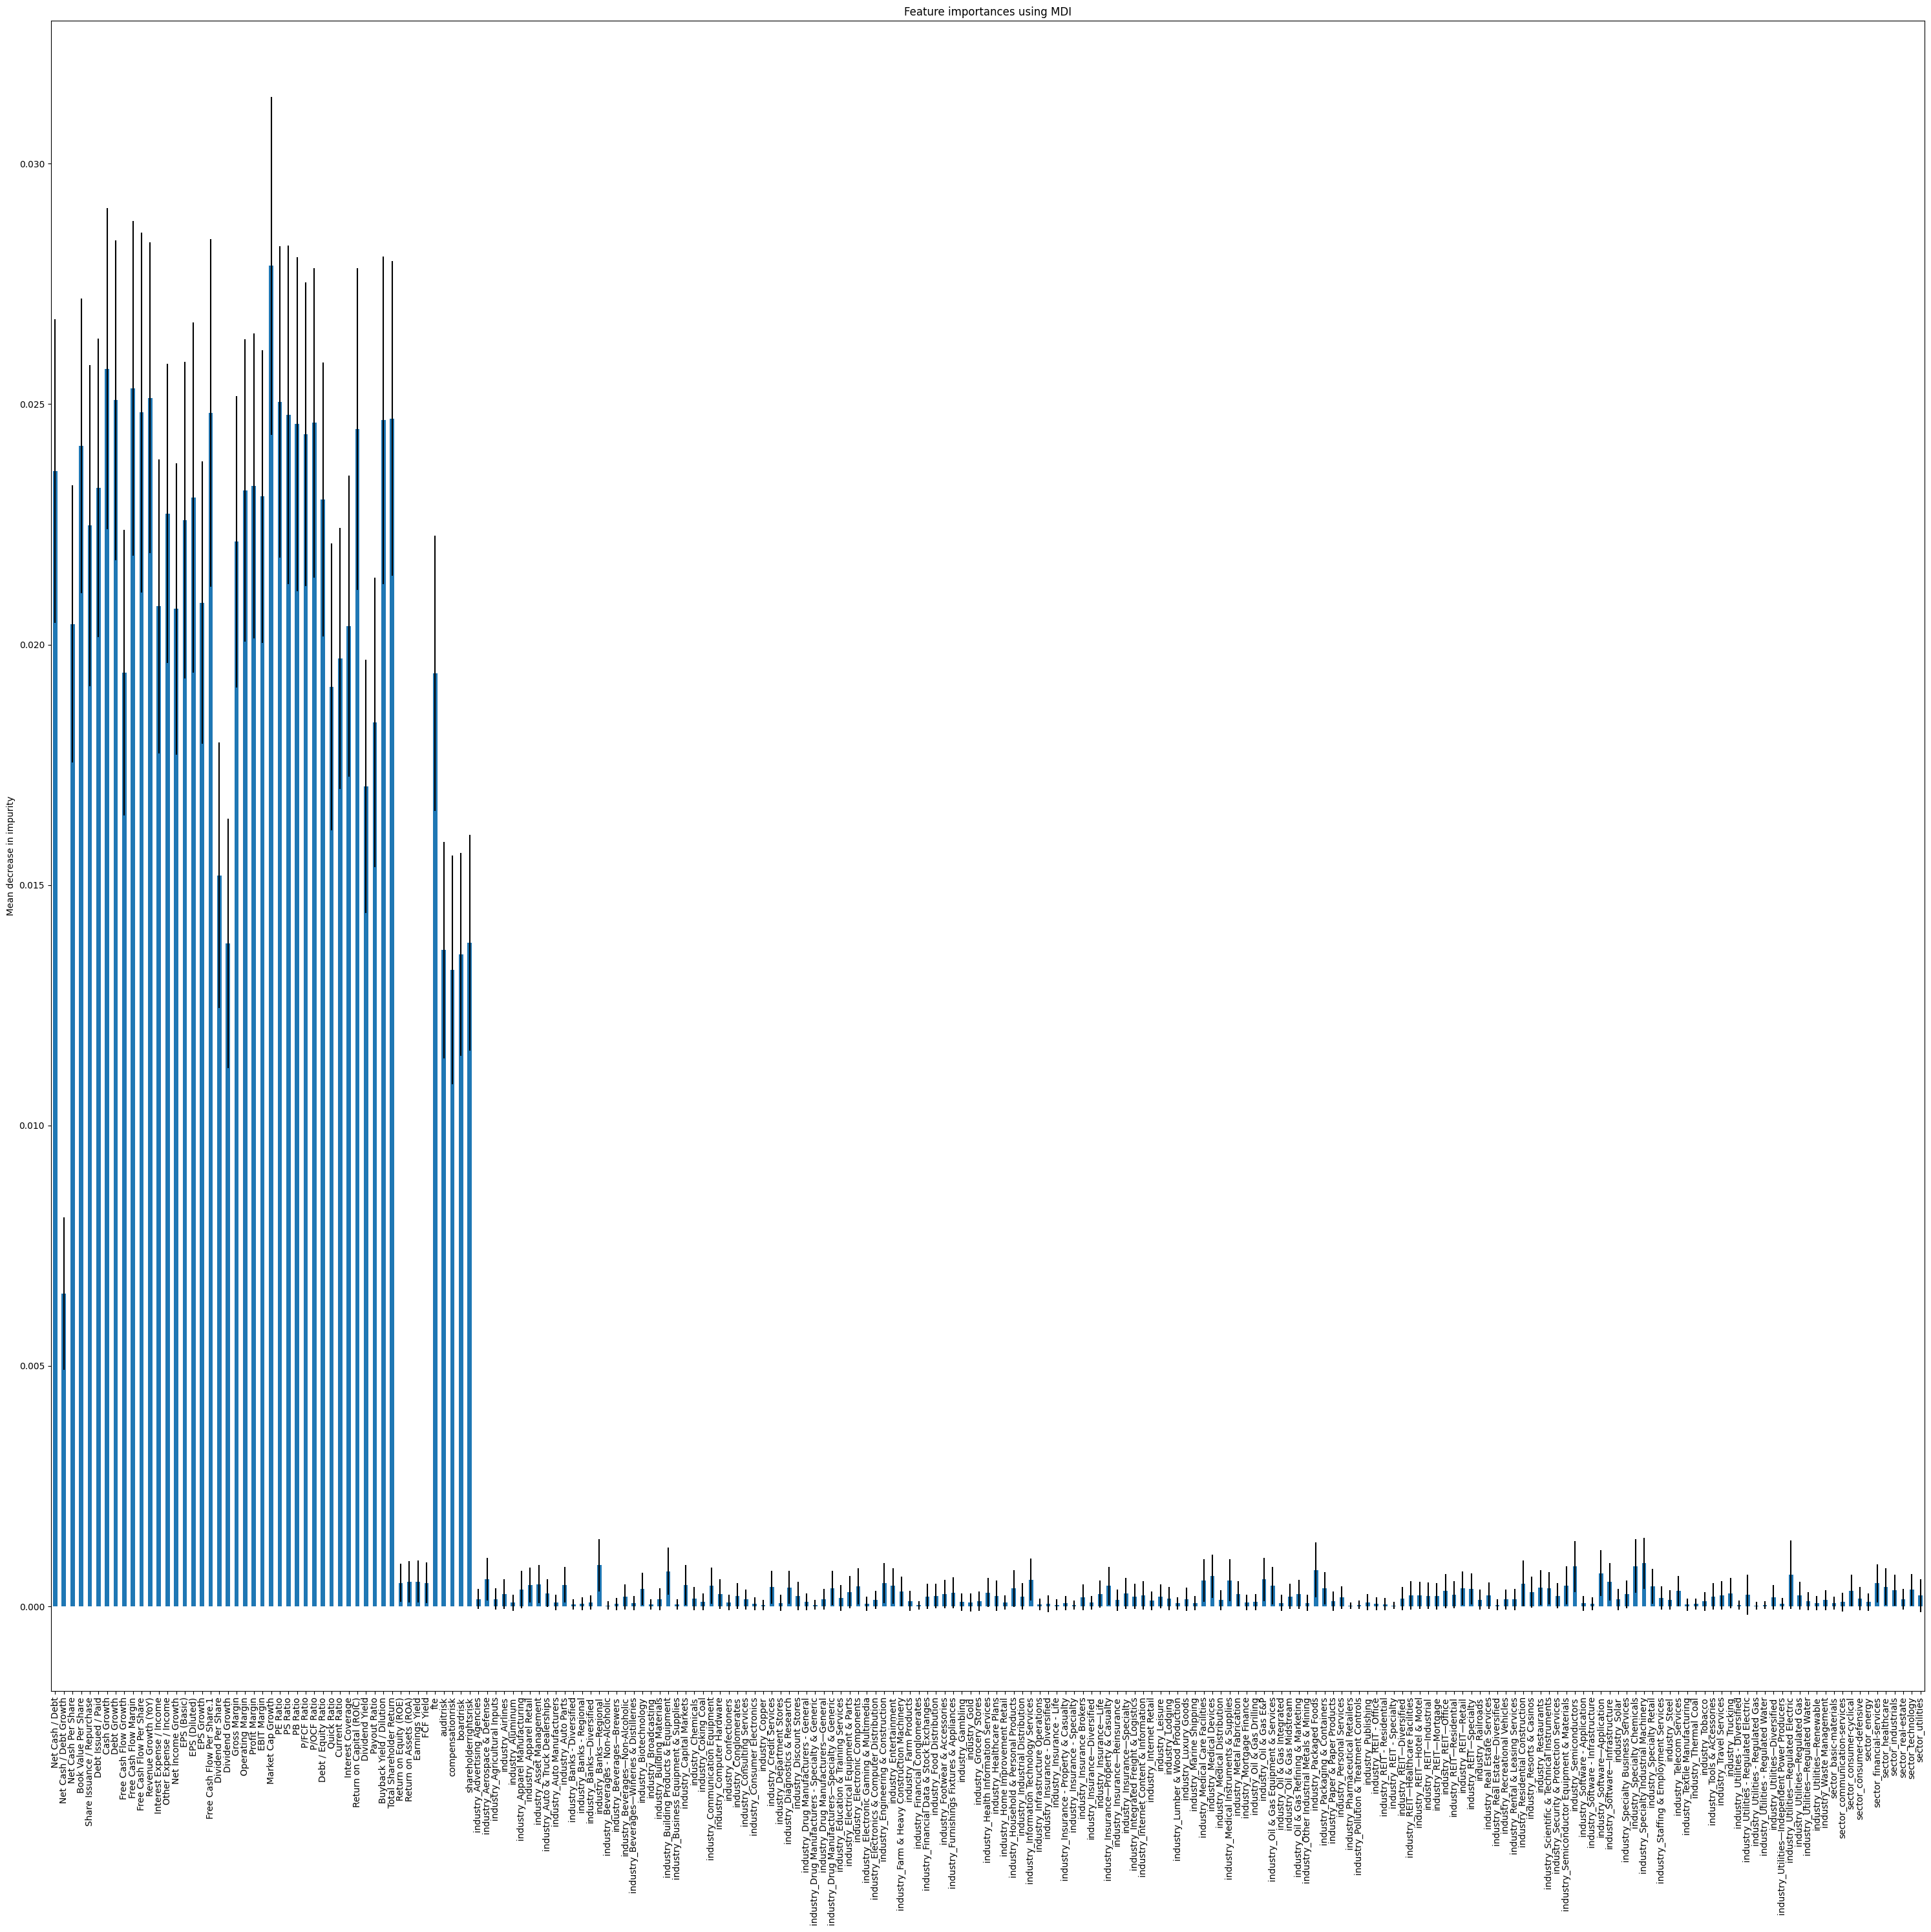

In [88]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=list(df_train.columns))
plt.figure(figsize=(16,16))
fig, ax = plt.subplots(figsize=(30,30))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig('feature_importances_plot.png')